In [3]:
import os
from tqdm import tqdm
from argparse import Namespace
from fairseq.data.encoders.gpt2_bpe import GPT2BPE
from fairseq.data import Dictionary
from datasets import load_dataset
import numpy as np
import itertools
DEFAULT_ENCODER_JSON = "https://dl.fbaipublicfiles.com/fairseq/gpt2_bpe/encoder.json"
DEFAULT_VOCAB_BPE = "https://dl.fbaipublicfiles.com/fairseq/gpt2_bpe/vocab.bpe"

/data/zyu401_data/anirudh/longmem/lib/python3.8/site-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


In [5]:
task_template_dict = {"SST-2": "Review: {} Sentiment: {}. ",
                          "sst-5": "Review: {} Sentiment: {}. ",
                            "mr": "Review: {} Sentiment: {}. ",
                          "mpqa": "Review: {} Sentiment: {}. ",
                          "subj": "Input: {} Type: {}. "}

def load_data(task):
    data = {}
    path = os.path.join("data/icl/original/", task)
    if task == "SST-2":
        for split in ["train", "validation",]:
            data[split] = []
            file_split = "dev" if split == "validation" else split
            
            with open(os.path.join(path, "{}.tsv".format(file_split)), "r") as f:
                for line in tqdm(f.readlines()):
                    review, label = line.strip("\n").split("\t")
                    if label == "label":
                        continue
                    label = "positive" if int(label) == 1 else "negative"
                    data[split].append([review, label])
    
    if task == "sst-5":
        mapping = {0: "terrible", 1: "bad", 2: "okay", 3: "good", 4: "great"}
        for split in ["train", "validation", "test"]:
            file_split = "dev" if split == "validation" else split
            if os.path.exists(os.path.join(path, "stsa.fine.{}".format(file_split))):
                data[split] = []
                with open(os.path.join(path, "stsa.fine.{}".format(file_split)), "r") as f:
                    for line in tqdm(f.readlines()):
                        review, label = line[2:], line[0]                        
                        label = mapping[int(label)]
                        data[split].append([review.strip("\n"), label])

    elif task in ["mr", "mpqa"]:
        for split in ["train", "validation", "test"]:
            if os.path.exists(os.path.join(path, "{}.csv".format(split))):
                data[split] = []
                with open(os.path.join(path, "{}.csv".format(split)), "r") as f:
                    for line in tqdm(f.readlines()):
                        review, label = line[2:], line[0]
                        label = "positive" if int(label) == 1 else "negative"
                        data[split].append([review.strip("\n"), label])
        print(data['test'][0])

    elif task in ["subj"]:
        for split in ["train", "test"]:
            if os.path.exists(os.path.join(path, "{}.csv".format(split))):
                data[split] = []
                with open(os.path.join(path, "{}.csv".format(split)), "r") as f:
                    for line in tqdm(f.readlines()):
                        review, label = line[2:], line[0]
                        label = "subjective" if int(label) == 0 else "objective"
                        data[split].append([review.strip("\n").strip('"'), label])
        print(data['test'][0])
    
    return data

In [6]:
tokenizer =  GPT2BPE(Namespace(gpt2_vocab_bpe=DEFAULT_VOCAB_BPE, gpt2_encoder_json=DEFAULT_ENCODER_JSON))
dictionary = Dictionary.load(os.path.join("gpt2_bpe", "dict.txt"))

In [7]:
def get_data(token_number, data, task_template):
    desired_num_tokens = token_number
    current_num_tokens = 0
    memory_set = []

    for idx, s in enumerate(data['train']):
        # Format the task template
        task_template_line = task_template.format(s[0], s[1])

        # Tokenize the line
        tokenized_line = tokenizer.encode(task_template_line)
        size = len(dictionary.encode_line(tokenized_line, add_if_not_exist=False).tolist())+1

        # Check if adding the current line exceeds the desired number of tokens
        if current_num_tokens + size <= desired_num_tokens:
            memory_set.append(task_template_line)
            current_num_tokens += size
        else:
            break  # Stop adding lines if the desired token limit is reached

    return memory_set

def get_imdb_data(token_number):
    imdb_dataset = load_dataset("imdb", cache_dir="/data/zyu401_data/anirudh/hf_data/")

    desired_num_tokens = token_number
    current_num_tokens = 0
    imdb_subset = []

    # Iterate through the IMDb dataset and tokenize reviews
    for example in imdb_dataset["train"]:
        review = example["text"]
        label = example["label"]
        concatenated_example = f"Review: {review} Label: {label}"
        tokenized_review = tokenizer.encode(concatenated_example)

        size = len(dictionary.encode_line(tokenized_review, add_if_not_exist=False).tolist())+1

        # Check if adding the current review exceeds the desired number of tokens
        if current_num_tokens + size <= desired_num_tokens:
            imdb_subset.append(concatenated_example)
            current_num_tokens += size
        else:
            print("EXEC FINE")
            break  # Stop adding reviews if the desired token limit is reached

    return imdb_subset



In [14]:
## Dataset 1
tasks = ["SST-2", "sst-5", "mr", "mpqa","subj"]
token_number = [6500//8+1, 6500//8+1, 6500//8+1, 6500//8+1, 6500//8+1]

data_comp = []
for i, task in enumerate(tasks):
    data = load_data(task)
    local_data = get_data(token_number[i], data, task_template_dict[task])
    data_comp.extend(local_data)

imdb_data = get_imdb_data(32500//8+1)
data_comp.extend(imdb_data)

tokenized_lines = [tokenizer.encode(line) for line in data_comp]
tokenized_ids = [[dictionary.bos()] + dictionary.encode_line(line, add_if_not_exist=False).tolist() for line in tokenized_lines]
article_tokens = list(itertools.chain(*tokenized_ids))

print(len(article_tokens))
data_comp = np.array(data_comp)
np.save('/data/zyu401_data/anirudh/d1.npy', data_comp)

100%|██████████| 2000/2000 [00:00<00:00, 1024375.14it/s]


['"simplistic , silly and tedious ."', 'negative']


100%|██████████| 2000/2000 [00:00<00:00, 1598743.66it/s]


['complaining', 'negative']


100%|██████████| 2000/2000 [00:00<00:00, 1313182.22it/s]


['smart and alert , thirteen conversations about one thing is a small gem .', 'subjective']


Found cached dataset imdb (/data/zyu401_data/anirudh/hf_data/imdb/plain_text/1.0.0/d613c88cf8fa3bab83b4ded3713f1f74830d1100e171db75bbddb80b3345c9c0)


  0%|          | 0/3 [00:00<?, ?it/s]

EXEC FINE
7966


In [16]:
## Dataset 2
tasks = ["SST-2", "sst-5", "mr", "mpqa","subj"]
token_number = [37500//8+1, 37500//8+1, 37500//8+1, 37500//8+1, 37500//8+1]

data_comp = []
for i, task in enumerate(tasks):
    data = load_data(task)
    local_data = get_data(token_number[i], data, task_template_dict[task])
    data_comp.extend(local_data)

imdb_data = get_imdb_data(62500)
data_comp.extend(imdb_data)

tokenized_lines = [tokenizer.encode(line) for line in data_comp]
tokenized_ids = [[dictionary.bos()] + dictionary.encode_line(line, add_if_not_exist=False).tolist() for line in tokenized_lines]
article_tokens = list(itertools.chain(*tokenized_ids))

print(len(article_tokens))

data_comp = np.array(data_comp)
np.save('/data/zyu401_data/anirudh/d2.npy', data_comp)

100%|██████████| 2000/2000 [00:00<00:00, 1456102.76it/s]


['"simplistic , silly and tedious ."', 'negative']


100%|██████████| 2000/2000 [00:00<00:00, 1588751.52it/s]


['complaining', 'negative']


100%|██████████| 2000/2000 [00:00<00:00, 1282465.68it/s]


['smart and alert , thirteen conversations about one thing is a small gem .', 'subjective']


Found cached dataset imdb (/data/zyu401_data/anirudh/hf_data/imdb/plain_text/1.0.0/d613c88cf8fa3bab83b4ded3713f1f74830d1100e171db75bbddb80b3345c9c0)


  0%|          | 0/3 [00:00<?, ?it/s]

EXEC FINE
85719


In [17]:
## Dataset 2
tasks = ["SST-2", "sst-5", "mr", "mpqa","subj"]
token_number = [200000//8+1, 200000//8+1, 200000//8+1, 200000//8+1, 200000//8+1]

data_comp = []
for i, task in enumerate(tasks):
    data = load_data(task)
    local_data = get_data(token_number[i], data, task_template_dict[task])
    data_comp.extend(local_data)

tokenized_lines = [tokenizer.encode(line) for line in data_comp]
tokenized_ids = [[dictionary.bos()] + dictionary.encode_line(line, add_if_not_exist=False).tolist() for line in tokenized_lines]
article_tokens = list(itertools.chain(*tokenized_ids))

print(len(article_tokens))

data_comp = np.array(data_comp)
np.save('/data/zyu401_data/anirudh/d3.npy', data_comp)

100%|██████████| 2000/2000 [00:00<00:00, 816409.54it/s]


['"simplistic , silly and tedious ."', 'negative']


100%|██████████| 2000/2000 [00:00<00:00, 1584849.42it/s]


['complaining', 'negative']


100%|██████████| 2000/2000 [00:00<00:00, 968214.22it/s]


['smart and alert , thirteen conversations about one thing is a small gem .', 'subjective']
124878


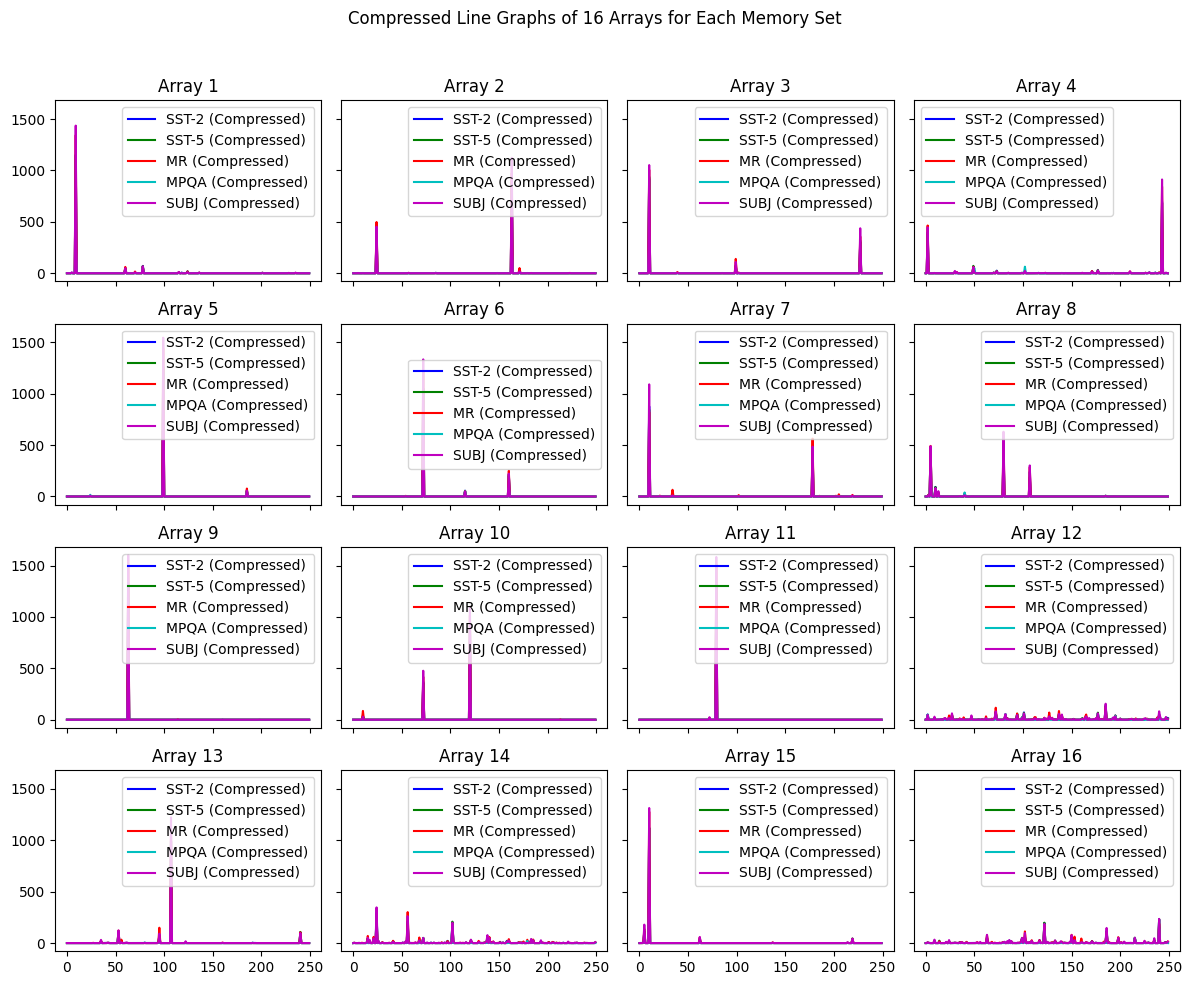

In [1]:
import matplotlib.pyplot as plt
import numpy as np

sst2_memory_set = np.load("/data/zyu401_data/zyu401/LongMem_vis/SST-2_1_1combine.npy", allow_pickle=True)
sst5_memory_set = np.load("/data/zyu401_data/zyu401/LongMem_vis/sst-5_1_1combine.npy", allow_pickle=True)
mr_memory_set = np.load("/data/zyu401_data/zyu401/LongMem_vis/mr_1_1combine.npy", allow_pickle=True)
mpqa_memory_set = np.load("/data/zyu401_data/zyu401/LongMem_vis/mpqa_1_1combine.npy", allow_pickle=True)
subj_memory_set = np.load("/data/zyu401_data/zyu401/LongMem_vis/subj_1_1combine.npy", allow_pickle=True)

def compress_array(arr, group_size):
    compressed_arr = [np.mean(arr[i:i+group_size]) for i in range(0, len(arr), group_size)]
    return compressed_arr

fig, axes = plt.subplots(nrows=4, ncols=4, figsize=(12, 10), sharex=True, sharey=True)

group_size = 1  # Adjust this value based on your requirement

# List of colors for each line
colors = ['b', 'g', 'r', 'c', 'm']

for i in range(4):
    for j in range(4):
        index = i * 4 + j
        axes[i, j].set_title(f'Array {index + 1}')

        for k, (memory_set, label) in enumerate(zip([sst2_memory_set, sst5_memory_set, mr_memory_set, mpqa_memory_set, subj_memory_set], ['SST-2', 'SST-5', 'MR', 'MPQA', 'SUBJ'])):
            # compressed_array = compress_array(memory_set[index], group_size)
            # axes[i, j].plot(memory_set[index], label=f'{label} (Compressed)', color=colors[k])
            compressed_array = compress_array(memory_set[index], group_size)
            axes[i, j].plot(compressed_array, label=f'{label} (Compressed)', color=colors[k])
        axes[i, j].legend()

plt.suptitle('Compressed Line Graphs of 16 Arrays for Each Memory Set')
plt.tight_layout(rect=[0, 0, 1, 0.96])  # Adjust subplot layout
plt.show()


In [8]:
print(sst5_memory_set)

[array([   25., 14755.,     0.,     0.,     0.,     0.,     0.,     0.,
            0.,     0.,     0.,     0.,     0.,     0.,     0.,     0.,
            0.,     0.,     0.,     0.,     0.,     0.,     0.,     0.,
            0.,     0.,     0.,     0.,     0.,     0.,     0.,     0.,
            0.,     0.,     0.,     0.,     0.,     0.,     0.,     0.,
            0.,     0.,     0.,     0.,     0.,     0.,     0.,     0.,
            0.,     0.])
 array([    0.,     0.,     0.,     0.,     0.,     0.,     0.,     0.,
            0.,    25., 14332.,     0.,     0.,     0.,     0.,     0.,
            0.,     0.,     0.,     0.,     0.,     0.,     0.,     0.,
            0.,     0.,     0.,     0.,     0.,     0.,     0.,     0.,
            0.,     0.,     0.,     0.,     0.,   423.,     0.,     0.,
            0.,     0.,     0.,     0.,     0.,     0.,     0.,     0.,
            0.,     0.])
 array([    0.,     0.,     0.,     0.,     0.,     0.,     0.,     0.,
            0.

In [9]:
print(sst2_memory_set)

[array([    0., 18355.,     0.,     0.,     0.,     0.,     0.,     0.,
            0.,     0.,     0.,     0.,     0.,     0.,     0.,     0.,
            0.,     0.,     0.,     0.,     0.,     0.,     0.,     0.,
            0.,     0.,     0.,     0.,     0.,     0.,     0.,     0.,
            0.,     0.,     0.,     0.,     0.,     0.,     0.,     0.,
            0.,     0.,     0.,     0.,     0.,     0.,     0.,     0.,
            0.,     0.])
 array([    0.,     0.,     0.,     0.,     0.,     0.,     0.,     0.,
            0.,     0., 17526.,     0.,     0.,     0.,     0.,     0.,
            0.,     0.,     0.,     0.,     0.,     0.,     0.,     0.,
            0.,     0.,     0.,     0.,     0.,     0.,     0.,     0.,
            0.,     0.,     0.,     0.,     0.,   829.,     0.,     0.,
            0.,     0.,     0.,     0.,     0.,     0.,     0.,     0.,
            0.,     0.])
 array([    0.,     0.,     0.,     0.,     0.,     0.,     0.,     0.,
            0.

In [10]:
subj_memory_set = np.load("/data/zyu401_data/anirudh/cluster/subj_1_1combine.npy", allow_pickle=True)
print(subj_memory_set.shape)
subj_memory_set[2]

(16,)


array([ 0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0., 19.,  0.,  0.,
        0.,  0.,  0.,  0.,  0.,  0.,  0.])

In [2]:
sst2_memory_set

array([array([ 3., 10.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,
               0.,  0.,  0.,  0.,  0.,  0.,  0.])                             ,
       array([ 0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0., 11.,  2.,  0.,  0.,
               0.,  0.,  0.,  0.,  0.,  0.,  0.])                             ,
       array([ 0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0., 13.,  0.,  0.,
               0.,  0.,  0.,  0.,  0.,  0.,  0.])                             ,
       array([ 0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0., 13.,  0.,
               0.,  0.,  0.,  0.,  0.,  0.,  0.])                             ,
       array([ 0.,  0.,  0.,  0.,  0.,  2.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,
               0.,  0.,  0.,  0.,  0., 11.,  0.])                             ,
       array([ 0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0., 13.,  0.,  0.,
               0.,  0.,  0.,  0.,  0.,  0.,  0.])                             ,
       array([0., 0., 0., 0., 0., 0., 0., 0., 